<a href="https://colab.research.google.com/github/Angelgz011/estadistica2/blob/main/TimeSeriesAnalysis_MINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar dataframe

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df = yf.download(
    tickers='COST',            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2023-01-01',        # Fecha de inicio
    end='2025-01-01',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df = df.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df['Date'] = pd.to_datetime(df['Date'])

df['Date'] = df['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df.set_index('Date', inplace=True)


df

[*********************100%***********************]  1 of 1 completed


,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume
Date,,,,,,
2023-01-03,85.459999,86.959999,84.209999,85.820000,85.820000,76706000
2023-01-04,86.550003,86.980003,83.360001,85.139999,85.139999,68885100
2023-01-05,85.330002,85.419998,83.070000,83.120003,83.120003,67930800
2023-01-06,83.029999,86.400002,81.430000,86.080002,86.080002,83303400
2023-01-09,87.459999,89.480003,87.080002,87.360001,87.360001,65266100
...,...,...,...,...,...,...
2024-12-24,226.940002,229.139999,226.130005,229.050003,229.050003,15007500
2024-12-26,228.500000,228.500000,226.669998,227.050003,227.050003,16146700
2024-12-27,225.600006,226.029999,220.899994,223.750000,223.750000,27367100


# Medias móviles

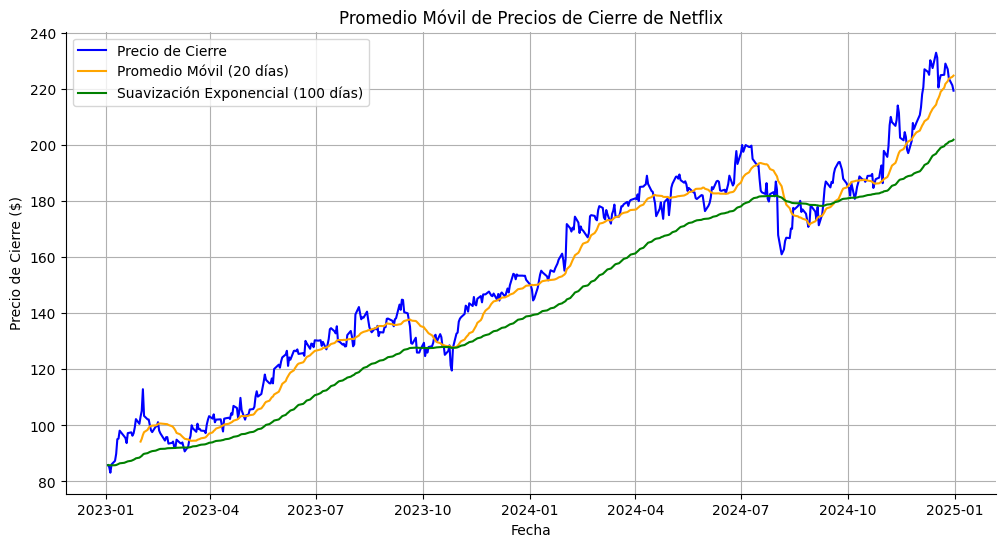

In [ ]:
# Promedio Móvil Simple
ventana_sma = 20
df['SMA'] = df['AMZN_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 100
df['SES'] = df['AMZN_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['AMZN_Close'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title('Promedio Móvil de Precios de Cierre de Netflix')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Prueba Dickey-Fuller Aumentada

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['AMZN_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")


Estadístico ADF: -0.8677899776777122
p-value: 0.7983945369763568
La tendencia no es estacionaria (aceptamos la hipótesis nula).


# Regresión polinomial

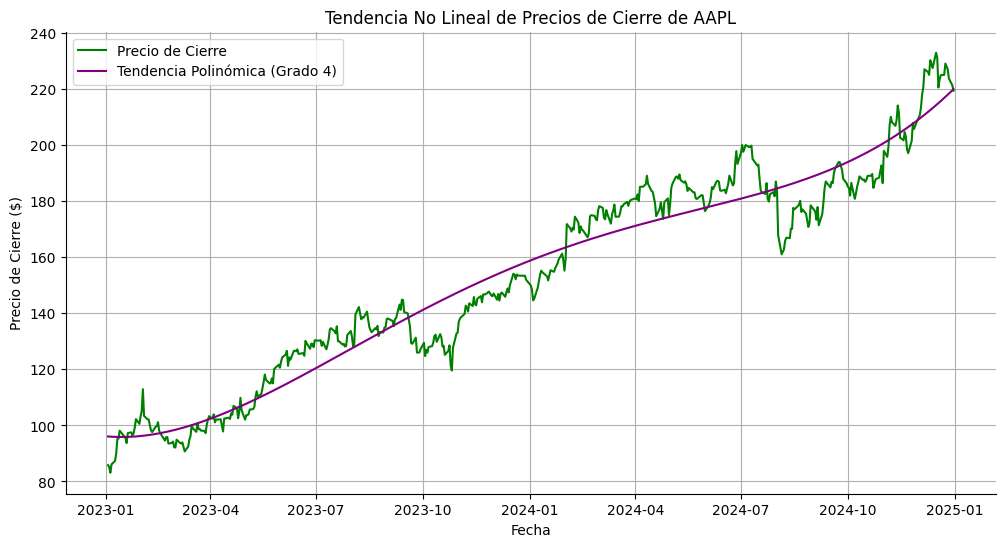

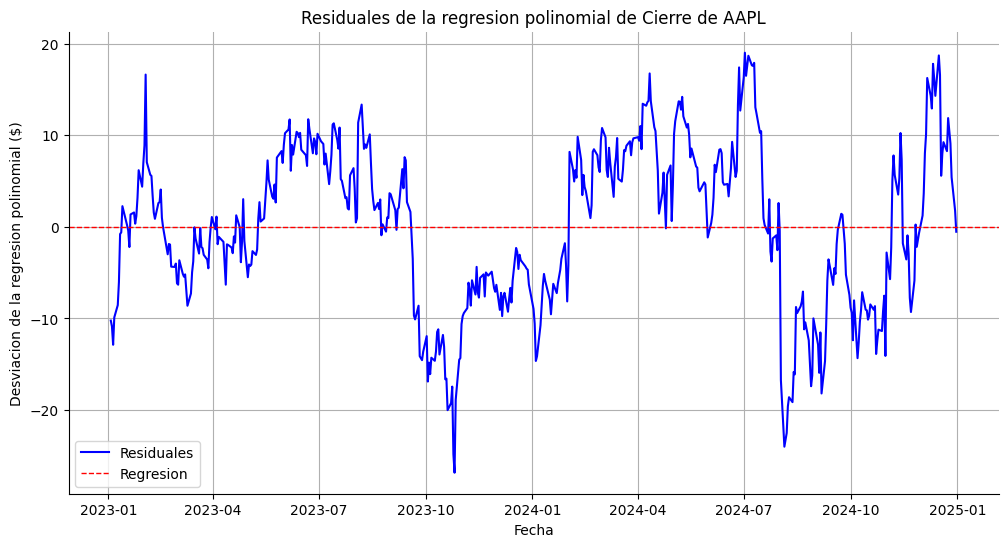

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['AMZN_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 4
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Para Pros: Series de Fourier

Las series de Fourier descomponen cualquier cosa como una suma de senos y cosenos. Por esta razón, son una herramienta útil para extraer patrones oscilantes. Este es un tema muy complicado y alejado a todo lo que han manejado, por esta razón no les voy a pedir que lo usen. Aquí lo he simplificado tanto como he podido por si se animan.

In [ ]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Frecuencias principales:
    frecuencia     magnitud  longitud_de_onda
0    0.003984  1671.115006        251.000000
1    0.005976  1524.998634        167.333333
2    0.007968   896.327678        125.500000
3    0.019920   740.364638         50.200000
4    0.013944   510.977390         71.714286


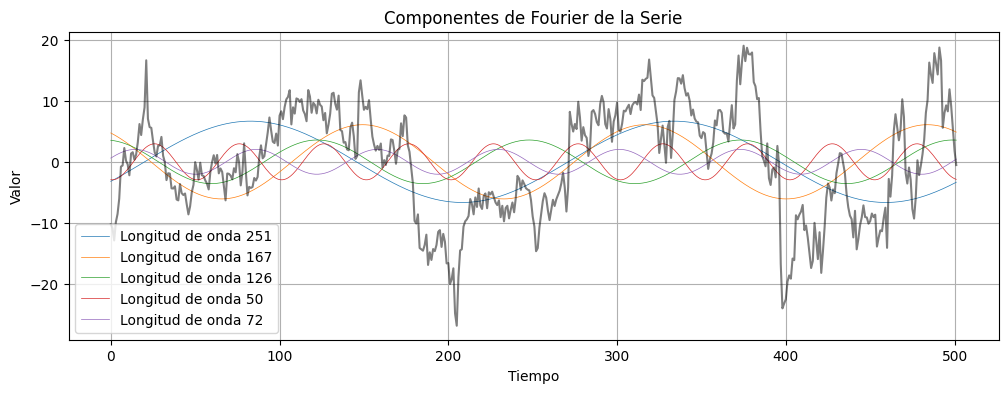

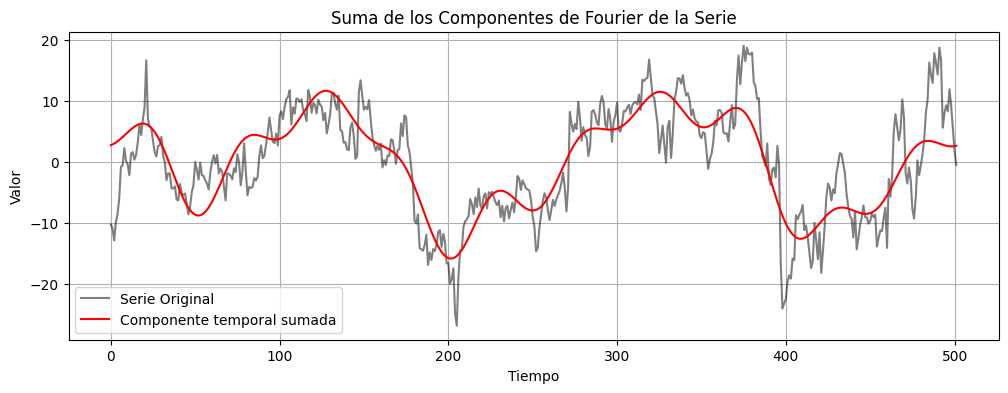

In [ ]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico)

# cts: componente temporal sumado


En estos gráficos, la longitud de onda equivale a la unidad de tiempo (en este caso, días) que tarda la onda en volver al mismo sitio. Algo que en nuestro contexto podríamos interpretar como estasionalidad. Vemos que la oscilación más grande se presenta cada 378 días. Dado que esto es más de un año, esto sería más bien un ciclo. Sin embargo, se puede apreciar algo muy interesante, la longitud de onda siguiente es de 126 en unidades de tiempo (días) que es justo la mitad de la cantidad de días de negociación en un año!!! 😯

# Gráfico de autocorrelación

El gráfico de autocorrelación tiene como eje vertical los valores de la r de Pearson objenidos desplazando la serie hacia atrás en el tiempo. La medida de estos desplazamientos se muestra en el eje horizontal "lags". Se puede ver que de fondo hay una especie de sombra, esa sombra muestra el intervalo de confianza con el nivel de significancia que establezcan. Si la r de Pearson para un lag específico está fuera fuera de esa sombra, hay un nivel de confianza para afirmar que $r\neq0$ y por lo tanto hay correlación.
<br>
Este gráfico se usa para muchas cosas. Nosotros lo intentamos usar para obtener la estacionalidad, pero también se usa para obtener algunos parámetros del modelo ARIMA.

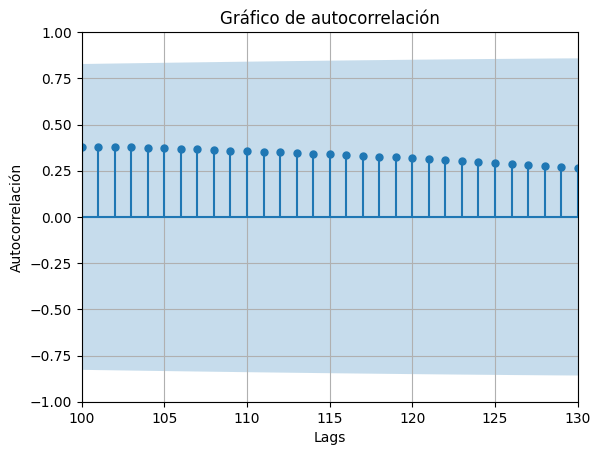

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

nivel_de_significancia = 0.05

plot_acf(
    df['AMZN_Close'],
    lags=130,
    alpha=nivel_de_significancia
    )

plt.xlim([100, 130])
plt.ylim([-1, 1])
plt.title('Gráfico de autocorrelación')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.grid()
plt.show()

# Gráfico de autocorrelación parcial (PACF)

Su propósito principal es ayudar a identificar el orden de dependencia en una serie temporal (útil para ARIMA), es decir, cuántos valores anteriores están correlacionados con el valor actual, después de eliminar el efecto de las observaciones intermedias.

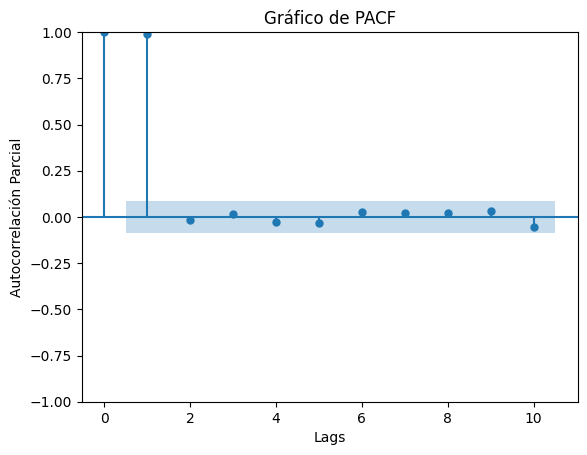

In [ ]:
# Generar el gráfico PACF
from statsmodels.graphics.tsaplots import plot_pacf

nivel_de_significancia = 0.05
plot_pacf(df['AMZN_Close'], lags=10, alpha=nivel_de_significancia)
plt.title('Gráfico de PACF')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.show()


# Descomposición de la serie

`sm.tsa.seasonal_descompose` descompone la serie de tiempo en los componentes Trend, Seasonal y Resid, que son Tendencia, Estacionalidad y Residuos, respectivamente. De tal manera que la serie de tiempo es igual la suma de estos tres elementos.

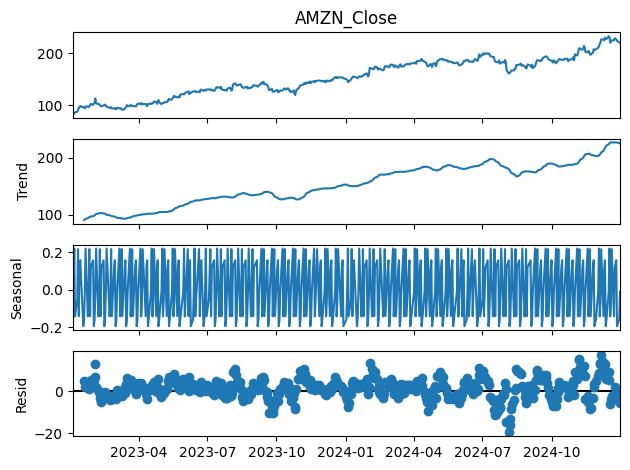

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['AMZN_Close'],
    model='additive',
    period=10,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

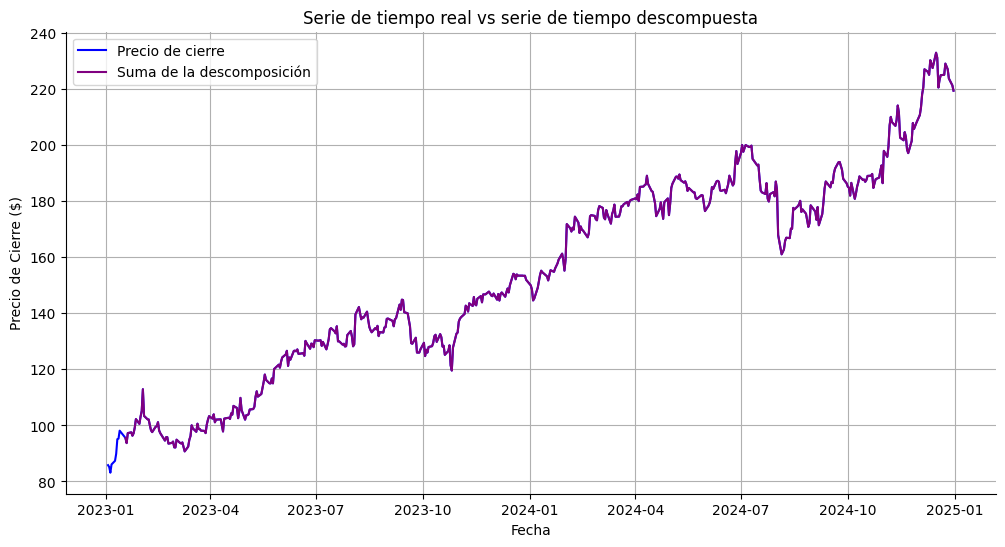

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AMZN_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

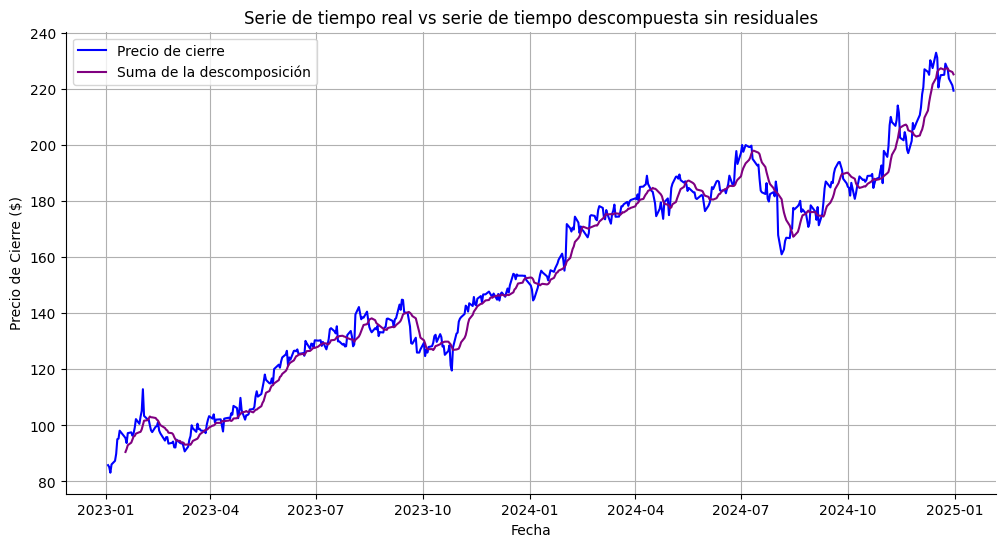

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AMZN_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(descomposicion.trend, label='Tendencia', color='blue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Tendencia y estacionalidad', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Importante**: Es posible que hayan campturado bien la estacionalidad y que la prueba ADF de los residuales les indique que hay estacionariedad. Sin embargo, en el gráfico anterior vemos que no hay mucha diferencia entre la tendencia y la tendencia con estacionalidad. Por lo tanto, la estacionalidad, aunque existe, no es significativa. Esto se ilustra en el siguiente gráfico.

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='blue')
plt.plot(descomposicion.trend + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin el componente estacional')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Prueba t pareada para verificar si la estacionalidad tiene un efecto significativo

In [ ]:
from scipy.stats import ttest_rel

# Prueba t pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes


nivel_de_significancia = 0.05
tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba t pareada
t_stat, p_valor = ttest_rel(tendencia, tendencia_estacionalidad)

print("Estadístico t:", t_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < nivel_de_significancia:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")


# Prueba Wilcoxon pareada para verificar si la estacionalidad tiene un efecto significativo

In [ ]:
from scipy.stats import wilcoxon

# Prueba Wilcoxon pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes

tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba de Wilcoxon
w_stat, p_valor = wilcoxon(tendencia, tendencia_estacionalidad)

print("Estadístico de Wilcoxon:", w_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < 0.05:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")


# Prueba Ljung-Box para autocorrelación

In [ ]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# Realizar la prueba de Ljung-Box
# Especifica los rezagos que deseas probar
lags = [21, 42, 63, 84, 126, 252]  # Puedes ajustar estos valores según tus necesidades
# [un mes, dos meses, tres meses, cuatro meses, seis meses, un año]

ljung_box_test = acorr_ljungbox(df['AAPL_Close'], lags=lags, return_df=True)

print(ljung_box_test)

# Interpretación de los resultados
for lag, p_valor in zip(ljung_box_test.index, ljung_box_test['lb_pvalue']):
    print("\n")
    if p_valor < 0.05:
        print(f"Para el rezago {lag}, el valor p es {p_valor:.4f}, que es menor que 0.05.")
        print("Conclusión: Rechazamos la hipótesis nula. Hay autocorrelación significativa en este rezago.")
    else:
        print(f"Para el rezago {lag}, el valor p es {p_valor:.4f}, que es mayor o igual que 0.05.")
        print("Conclusión: No podemos rechazar la hipótesis nula. No hay autocorrelación significativa en este rezago.")


# Modelo ARIMA

In [ ]:
# Estimación de p para ARIMA, se toma el último pico

# Generar el gráfico PACF
from statsmodels.graphics.tsaplots import plot_pacf

nivel_de_significancia = 0.05
plot_pacf(df['AAPL_Close'], lags=10, alpha=nivel_de_significancia)
plt.title('Gráfico de PACF')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.show()

Para obtener `d` hacemos diferenciaciones aplicando ADF a las diferencias hasta que la diferenciación se vuelva estacionaria.

In [ ]:
diferencia_1 = df['AAPL_Close'].diff()     # Primera diferencia

#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(diferencia_1.dropna())

print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

In [ ]:
# Obtener q. Se sustituyen p y d que obtuvimos arriba y se busca la minimización de AIC

from statsmodels.tsa.arima.model import ARIMA

p = 1
d = 1

# Prueba varios valores de q
for q in range(0, 7):  # Probar con valores de q de 0 a 3
    modelo = ARIMA(df['AAPL_Close'], order=(p, d, q))  # Usa p y d obtenidos previamente
    modelo_ajustado = modelo.fit()
    print(f"Para q={q}, AIC={modelo_ajustado.aic}")


KeyError: 'AAPL_Close'

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Ajustar el modelo ARIMA con parámetros específicos
p = 1
d = 1
q = 1
modelo_arima = ARIMA(df['AAPL_Close'], order=(p, d, q))
modelo_ajustado = modelo_arima.fit()

# Predicción para los próximos 100 puntos
numero_de_predicciones = 100
predicciones = modelo_ajustado.forecast(steps=numero_de_predicciones)

# Crear un índice para las predicciones
indice_predicciones = pd.date_range(df['AAPL_Close'].index[-1] + pd.Timedelta(days=1), periods=numero_de_predicciones)

# Visualizar los resultados
plt.figure(figsize=(10, 5))
plt.plot(df['AAPL_Close'], label="Serie Original")
plt.plot(indice_predicciones, predicciones, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Predicción con ARIMA")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.legend()
plt.show()


# Enfoque auto_arima

In [ ]:
# primero hay que instalar
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

# Ajustar el modelo ARIMA automáticamente
modelo_auto = auto_arima(df['AAPL_Close'], start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True, stepwise=True)

# Resumen del modelo seleccionado
print(modelo_auto.summary())

# Predicción para los próximos 10 puntos
numero_de_predicciones = 100
predicciones = modelo_auto.predict(n_periods=numero_de_predicciones)

# Crear un índice para las predicciones
indice_predicciones = pd.date_range(df['AAPL_Close'].index[-1] + pd.Timedelta(days=1), periods=numero_de_predicciones)

# Visualizar los resultados
plt.figure(figsize=(10, 5))
plt.plot(df['AAPL_Close'], label="Serie Original")
plt.plot(indice_predicciones, predicciones, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Predicción con auto_arima")
plt.legend()
plt.show()


# Modelo SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros no estacionales (p, d, q)
p = 1
d = 1
q = 1

# Parámetros estacionales (P, D, Q, s)
P = 1     # Orden autorregresivo estacional
D = 1     # Diferenciación estacional
Q = 1     # Orden de media móvil estacional
s = 20    # Periodo de estacionalidad

# Ajustar el modelo SARIMA con parámetros específicos
modelo_sarima = SARIMAX(df['AAPL_Close'], order=(p, d, q), seasonal_order=(P, D, Q, s))
modelo_ajustado = modelo_sarima.fit()

# Predicción para los próximos 100 puntos
numero_de_predicciones = 100
predicciones = modelo_ajustado.forecast(steps=numero_de_predicciones)

# Crear un índice para las predicciones
indice_predicciones = pd.date_range(df['AAPL_Close'].index[-1] + pd.Timedelta(days=1), periods=numero_de_predicciones)

# Visualizar los resultados
plt.figure(figsize=(10, 5))
plt.plot(df['AAPL_Close'], label="Serie Original")
plt.plot(indice_predicciones, predicciones, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Predicción con SARIMA")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.legend()
plt.show()


KeyError: 'AAPL_Close'

# Prophet

In [ ]:
# Este data frame son del siguiente año a df. Esto con el propósito de testear prophet
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df2 = yf.download(
    tickers='AAPL',            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2018-01-01',        # Fecha de inicio
    end='2018-12-30',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df2 = df2.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df2.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df2.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df2['Date'] = pd.to_datetime(df2['Date'])

df2['Date'] = df2['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df2.set_index('Date', inplace=True)


df2

[*********************100%***********************]  1 of 1 completed


,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.479824,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.472782,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.660793,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.123734,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,40.970970,82271200
...,...,...,...,...,...,...
2018-12-21,39.215000,39.540001,37.407501,37.682499,35.952221,382978400
2018-12-24,37.037498,37.887501,36.647499,36.707500,35.021988,148676800
2018-12-26,37.075001,39.307499,36.680000,39.292500,37.488293,234330000


In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

# Crear el modelo y ajustarlo
modelo = Prophet()
modelo.fit(df['AAPL_Close'].reset_index().rename(columns={'Date': 'ds', 'AAPL_Close': 'y'}))

# Predicción para los próximos 365 días
futuro = modelo.make_future_dataframe(periods=365)
predicciones = modelo.predict(futuro)

# Visualizar las predicciones
fig = modelo.plot(predicciones)
plt.plot(df2['AAPL_Close'], label='Serie Original', color='red')
plt.xlabel('Fecha')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Predicción con Prophet')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
fig = modelo.plot_components(predicciones)



KeyError: 'AAPL_Close'

In [ ]:
from prophet import Prophet

# Crear el modelo y ajustarlo
# Personalizando el modelo lo arruinamos :(
modelo = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_mode='multiplicative',
    yearly_seasonality=10,
    weekly_seasonality=True,
    interval_width=0.95
)
modelo.fit(df['AAPL_Close'].reset_index().rename(columns={'Date': 'ds', 'AAPL_Close': 'y'}))

# Predicción para los próximos 365 días
futuro = modelo.make_future_dataframe(periods=365)
predicciones = modelo.predict(futuro)

# Visualizar las predicciones
fig = modelo.plot(predicciones)
plt.plot(df2['AAPL_Close'], label='Serie Original', color='red')
plt.xlabel('Fecha')
fig = modelo.plot_components(predicciones)



# Más de una serie temporal a la vez

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df = yf.download(
    tickers=['AAPL', 'NVDA'],            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2015-01-01',        # Fecha de inicio
    end='2018-01-01',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df = df.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df['Date'] = pd.to_datetime(df['Date'])

df['Date'] = df['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df.set_index('Date', inplace=True)


df

In [ ]:
# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['AAPL_Close'], label='Apple', color='blue')
plt.plot(df['NVDA_Close'], label='NVIDIA', color='purple')
plt.title('Precios de Cierre de AAPL y NVIDIA')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Causalidad de Granger

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Hipótesis Nula (H₀): La serie X no causa en el sentido de Granger a la serie Y.

# Hipótesis Alternativa (H₁): La serie X causa en el sentido de Granger a la serie Y.

# Definir el número máximo de rezagos para la prueba
max_lags = 5

# Realizar la prueba de causalidad de Granger
# La función devuelve resultados para varios tests y cada rezago hasta el máximo definido
resultado = grangercausalitytests(df[['AAPL_Close', 'NVDA_Close']], max_lags, verbose=True)


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Hipótesis Nula (H₀): La serie X no causa en el sentido de Granger a la serie Y.

# Hipótesis Alternativa (H₁): La serie X causa en el sentido de Granger a la serie Y.

# Definir el número máximo de rezagos para la prueba
max_lags = 5

# Realizar la prueba de causalidad de Granger
# La función devuelve resultados para varios tests y cada rezago hasta el máximo definido
resultado = grangercausalitytests(df[['NVDA_Close', 'AAPL_Close']], max_lags, verbose=True)